In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage as ski
from scipy import ndimage as ndi
from skimage import data, util, filters, color
from skimage.segmentation import watershed


def read_data(id):
    # Leer el archivo de datos correspondiente al id de la galaxia
    file_path = f'../DATA/processed/TracingPoints/data_rho_{id}_filtered.csv'
    data = pd.read_csv(file_path)
    return data

def sort_by_delta_rho(data):
    # Ordenar las partículas por deltaRho en orden decreciente
    sorted_data = data.sort_values(by='deltaRho', ascending=False).reset_index(drop=True)
    return sorted_data

# Colores
h_alpha_color = '#DC143C'  # emisiones H-alpha - Carmesí o rojo 

In [94]:
id_halo = 11
data = read_data(id_halo)

sorted_data = sort_by_delta_rho(data)

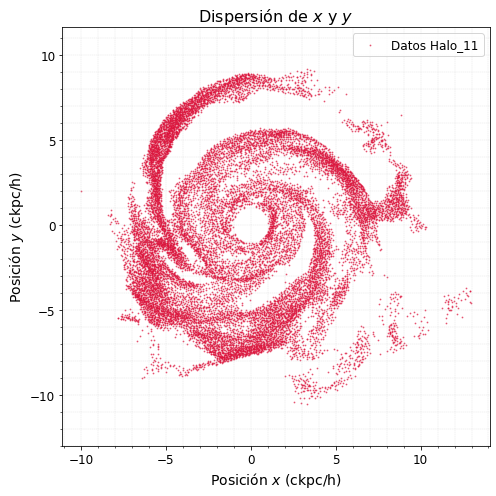

In [95]:
x = sorted_data['x']
y = sorted_data['y']

# Figura x,y halo
fig, ax = plt.subplots(figsize=(7, 7))

scatter = ax.scatter(x, y, c=h_alpha_color, s=0.7, alpha=0.6, label=f'Datos Halo_{id_halo}')

ax.set_title(r'Dispersión de $x$ y $y$', fontsize=16)
ax.set_xlabel(r'Posición $x$ (ckpc/h)', fontsize=14)
ax.set_ylabel(r'Posición $y$ (ckpc/h)', fontsize=14)
ax.legend(loc='best', fontsize=12)

ax.grid(True, which='both', linestyle='--', linewidth=0.4, alpha=0.4)
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.axis('equal')

plt.tight_layout()
plt.show()


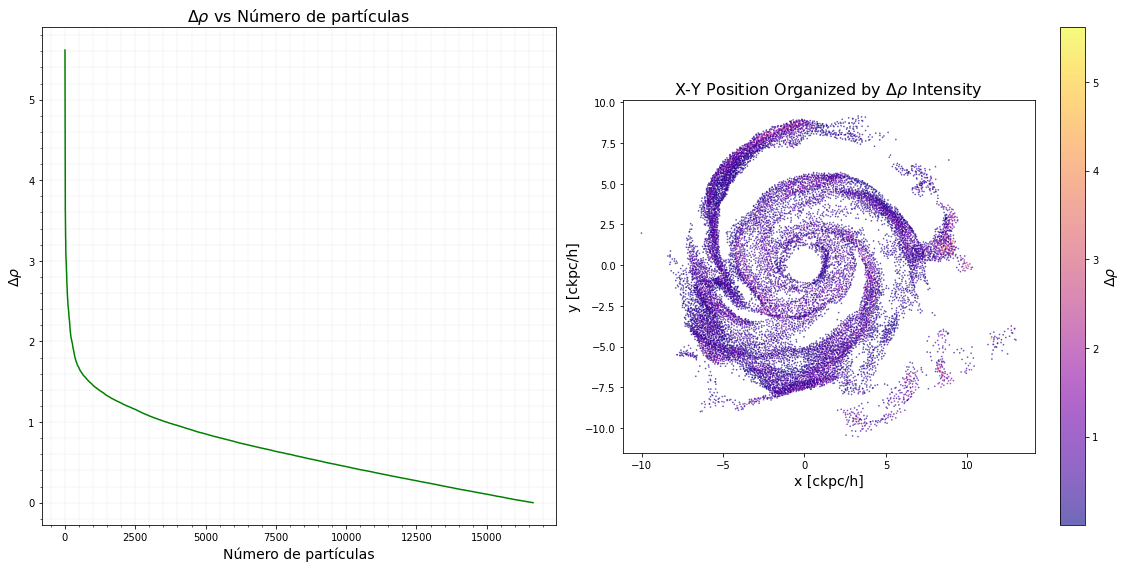

In [96]:
# Datos
x = sorted_data['x']
y = sorted_data['y']
delta_rho = sorted_data['deltaRho']
num_particles = range(1, len(delta_rho) + 1)

# Gráficas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Primer gráfico: DeltaRho vs Número de partículas
ax1.plot(num_particles, delta_rho, color='g', linewidth=1.5)
ax1.set_title(r'$\Delta \rho$ vs Número de partículas', fontsize=16)
ax1.set_xlabel(r'Número de partículas', fontsize=14)
ax1.set_ylabel(r'$\Delta \rho$', fontsize=14)
ax1.grid(True, which='both', linestyle='--', linewidth=0.4, alpha=0.4)
ax1.minorticks_on()

# Segundo gráfico: Posición X-Y de las partículas, organizadas por la intensidad de DeltaRho
scatter = ax2.scatter(x, y, c=delta_rho, cmap='plasma', s=0.5, alpha=0.6)
ax2.set_title(r'X-Y Position Organized by $\Delta \rho$ Intensity', fontsize=16)
ax2.set_xlabel('x [ckpc/h]', fontsize=14)
ax2.set_ylabel('y [ckpc/h]', fontsize=14)
ax2.set_aspect('equal', adjustable='box')

# Barra de color
cbar = fig.colorbar(scatter, ax=ax2, orientation='vertical')
cbar.set_label(r'$\Delta \rho$', fontsize=14)


plt.tight_layout()
plt.show()


## Cartesian to Polar Transformations
To transform Cartesian coordinates \((x, y)\) into polar coordinates \((r, $\phi$)\), we use the following mathematical relationships:

$$
r = \sqrt{x^2 + y^2}
$$

$$
\phi = \text{atan2}(y, x)
$$

Here, \( r \) is the radial distance from the origin, and \( $\phi$ \) is the angle (in radians) measured counterclockwise from the positive \(x\)-axis.


## Inverse Polar to Cartesian:
These transformations:

$$
x = r \cdot \cos(\phi)
$$
$$
y = r \cdot \sin(\phi)
$$


In [97]:
#funciones

def cartesian_to_polar(x, y):
    """
    Convert Cartesian coordinates (x, y) to polar coordinates (r, phi).
    
    Parameters:
    x : array-like
        x-coordinates.
    y : array-like
        y-coordinates.
    
    Returns:
    r : array-like
        Radial distance from the origin.
    phi : array-like
        Angle in radians.
    """
    # Calculate radial distance
    r = np.sqrt(x**2 + y**2)
    
    # Calculate the angle using atan2 (handles all quadrants)
    phi = np.arctan2(y, x)
    
    return r, phi


def polar_to_cartesian(r, phi):
    """
    Convert polar coordinates (r, phi) to Cartesian coordinates (x, y).
    
    Parameters:
    r : array-like
        Radial distance from the origin.
    phi : array-like
        Angle in radians.
    
    Returns:
    x : array-like
        x-coordinates.
    y : array-like
        y-coordinates.
    """
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    
    return x, y


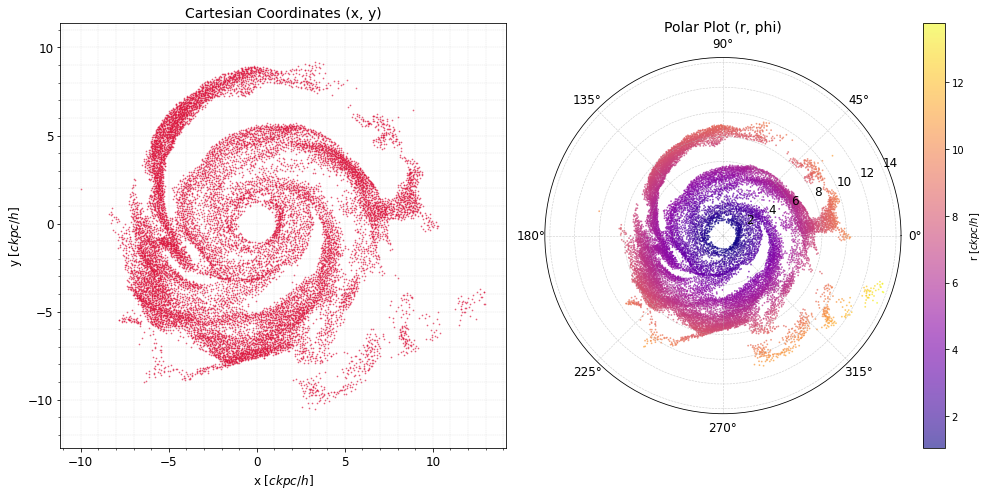

In [98]:

x_values_s = sorted_data['x'].values
y_values_s = sorted_data['y'].values

# Convert to polar coordinates
r_values_sorted, phi_values_sorted = cartesian_to_polar(x_values_s, y_values_s)

# Plotting the Cartesian and Polar Coordinates
fig = plt.figure(figsize=(14, 7))

# Plot Cartesian coordinates
ax1 = fig.add_subplot(121)
ax1.scatter(x_values_s, y_values_s, c=h_alpha_color, s=0.5, alpha=0.6)
ax1.set_title('Cartesian Coordinates (x, y)', fontsize=14)
ax1.set_xlabel('x [$\it{ckpc/h}$]', fontsize=12)
ax1.set_ylabel('y [$\it{ckpc/h}$]', fontsize=12)
ax1.set_aspect('equal')
ax1.grid(True, which='both', linestyle='--', linewidth=0.4, alpha=0.4)
ax1.minorticks_on()
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='both', which='minor', labelsize=10)
ax1.axis('equal')

# Plot Polar coordinates 
ax2 = fig.add_subplot(122, projection='polar')
sc = ax2.scatter(phi_values_sorted, r_values_sorted, c=r_values_sorted, cmap='plasma', s=0.7, alpha=0.6)
ax2.set_title('Polar Plot (r, phi)', fontsize=14)
ax2.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.6)
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.colorbar(sc, ax=ax2, label='r [$\it{ckpc/h}$]')

plt.tight_layout()
plt.show()



## A new formula describing the scaffold structure of spiral galaxies

The formula presented in the article is:

$$
r(\phi) = \frac{A}{\log \left( B \tan \left( \frac{\phi}{2N} \right) \right)}
$$

Where:
- \( A \) is a scale parameter,
- \( B \) controls the bulge-to-arm size,
- \( N \) determines the spiral's tightness, and
- \( $\phi $\) is the polar angle.


- **`spiral_structure`** function takes the angle \( $\phi$ \), and parameters \( A \), \( B \), and \( N \) to compute the radial distance \( r($\phi$) \) for the spiral.

  
### Customization:
- You can adjust the parameters \( A \), \( B \), and \( N \) based on the specific galaxy morphology or dataset.
- The formula allows flexibility in fitting different types of spiral structures, and you can fine-tune these parameters to fit your galaxy data.



In [99]:
def spiral_structure(phi, A, B, N):
    """
    Calculate r(phi) based on the formula in the article.
    r(φ) = A / log(B * tan(φ / 2N))
    
    Parameters:
    phi : array-like
        Array of angle values in radians.
    A : float
        Scale parameter for the spiral.
    B : float
        Parameter that controls the bulge-to-arm size.
    N : float
        Winding number that controls the spiral's tightness.
    
    Returns:
    r : array-like
        Radial distances corresponding to the angle values.
    """
    r = A / np.log(B * np.tan(phi / (2 * N)))
    return r

The formula presented in the article is:

\[
r(\phi) = \frac{A}{\log \left( B \tan \left( \frac{\phi}{2N} \right) \right)}
\]

where:

- \( r \) is the radial distance (in polar coordinates),
- \( \phi \) is the angle in radians,
- \( A \) is a scaling factor (which you've mentioned is 1),
- \( B \) is a parameter controlling the bar-to-arm transition,
- \( N \) is the winding number that determines the pitch of the spiral.

### Inverse Transformation
To extract \( B \) and \( N \) given \( r \) and \( \phi \), we need to invert the formula.

1. **Start with the formula**:

   \[
   r = \frac{1}{\log \left( B \tan \left( \frac{\phi}{2N} \right) \right)}
   \]

2. **Take the logarithm** on both sides to eliminate the logarithmic term:

   \[
   \log \left( B \tan \left( \frac{\phi}{2N} \right) \right) = \frac{1}{r}
   \]

3. **Exponentiate both sides** to remove the logarithm:

   \[
   B \tan \left( \frac{\phi}{2N} \right) = e^{\frac{1}{r}}
   \]

4. **Solve for \( B \)**:

   \[
   B = \frac{e^{\frac{1}{r}}}{\tan \left( \frac{\phi}{2N} \right)}
   \]

   At this point, you can calculate \( B \) if you know \( N \).

5. **To isolate \( N \)**, you'll need to use the known values of \( r \), \( \phi \), and some initial guess for \( B \) (or a range of \( B \) values if you’re iterating over possible solutions). The equation doesn't allow for a simple closed-form solution for \( N \), but you could solve it numerically by rewriting it as:

   \[
   \frac{\phi}{2N} = \tan^{-1} \left( \frac{e^{\frac{1}{r}}}{B} \right)
   \]

   Which implies:

   \[
   N = \frac{\phi}{2 \tan^{-1} \left( \frac{e^{\frac{1}{r}}}{B} \right)}
   \]

### Numerical Estimation
To determine \( B \) and \( N \), we can use numerical methods like least squares fitting or optimization techniques such as gradient descent, based on your input values of \( r \) and \( \phi \). Given that the equation involves both \( B \) and \( N \), you might need to use a method that iterates over one variable while fitting the other.

Would you like to proceed with writing Python code to numerically estimate \( B \) and \( N \) using this approach?

## AJuste con curve_fit

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log
  if sys.path[0] == '':


Parámetros ajustados: A = -0.5030690658648425, B = 1.133603558405297, N = 0.9888308798205969


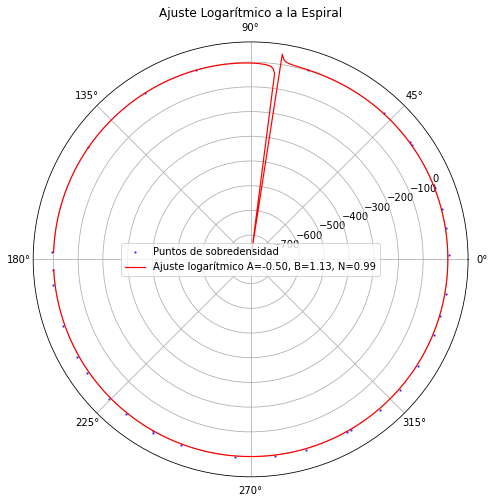

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Definir la función de espiral logarítmica que queremos ajustar
def log_spiral(phi, A, B, N):
    """
    r(φ) = A / log(B * tan(φ / 2N))
    """
    safe_phi = np.clip(phi, 1e-6, None)  # Evitar valores problemáticos para tan y log
    return A / np.log(B * np.tan(safe_phi / (2 * N)) + 1e-6)

# Función para convertir de coordenadas cartesianas a polares
def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return r, phi

# Cargar los datos de puntos (x, y) para convertirlos en coordenadas polares
data_arm = pd.read_csv('../DATA/processed/TracingPoints/arm_tracing_11_arm1_rho_dani.csv')

# Extraer los valores de x e y
x_values = data_arm['x'].values
y_values = data_arm['y'].values

# Convertir a coordenadas polares (r, φ)
r_values, phi_values = cartesian_to_polar(x_values, y_values)

# Función de ajuste por mínimos cuadrados no lineales usando curve_fit de scipy
def fit_log_spiral_numerical(r_values, phi_values):
    # Definir una conjetura inicial para los parámetros A, B y N
    initial_guess = [1.0, 1.0, 1.0]
    
    # Ajustar los datos con curve_fit
    try:
        popt, pcov = curve_fit(log_spiral, phi_values, r_values, p0=initial_guess, maxfev=10000)
    except RuntimeError:
        print("No se pudo ajustar el modelo a los datos")
        return None, None

    # Retornar los parámetros ajustados (A, B, N)
    return popt, pcov

# Ajustar el modelo y obtener los parámetros A, B y N
params, covariance = fit_log_spiral_numerical(r_values, phi_values)

if params is not None:
    A_fit, B_fit, N_fit = params
    print(f"Parámetros ajustados: A = {A_fit}, B = {B_fit}, N = {N_fit}")

    # Graficar los puntos y el ajuste de la espiral
    phi_fit = np.linspace(np.min(phi_values), np.max(phi_values), 500)
    r_fit = log_spiral(phi_fit, A_fit, B_fit, N_fit)

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))
    ax.scatter(phi_values, r_values, color='blue', s=2, alpha=0.6, label='Puntos de sobredensidad')
    ax.plot(phi_fit, r_fit, label=f'Ajuste logarítmico A={A_fit:.2f}, B={B_fit:.2f}, N={N_fit:.2f}', color='red', linewidth=1.2)
    ax.set_title('Ajuste Logarítmico a la Espiral')
    ax.legend()
    plt.show()
else:
    print("No se pudo realizar el ajuste")


### 2do intento

-
Usando scipy
-

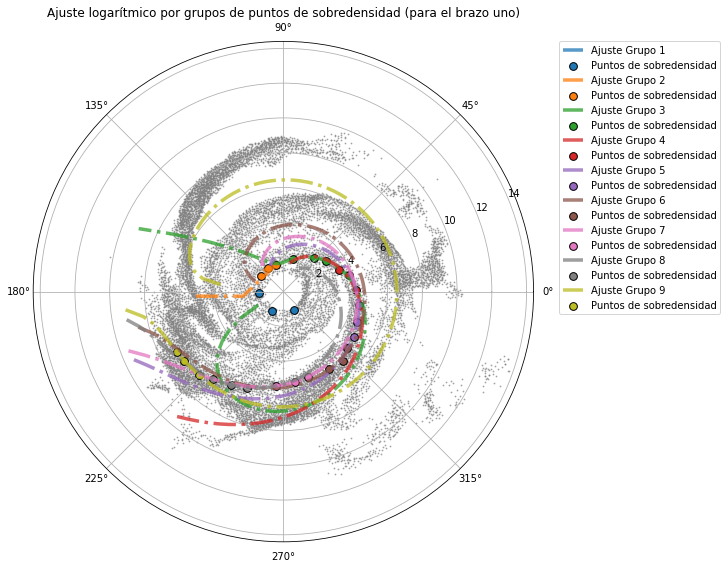

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import BayesianRidge

# Definir la función logarítmica de la espiral incluyendo A, B y N
def log_spiral(phi, A, B, N):
    """
    r(φ) = A / log(B * tan(φ / 2N))
    """
    safe_phi = np.clip(phi, 1e-6, None)  # Evitar valores problemáticos para tan y log
    return A / np.log(B * np.tan(safe_phi / (2 * N)) + 1e-6)

# Clase para crear un ajuste Bayesiano
class BayesianSpiralFitter:
    def __init__(self, alpha_1=1e-6, lambda_1=1e-6):
        self.bayesian_ridge = BayesianRidge(alpha_1=alpha_1, lambda_1=lambda_1)
        self.A_ = None
        self.B_ = None
        self.N_ = None
        self.r2_score_ = None

    def fit(self, phi, r):
        # Preprocesar los valores de phi, ahora con tres características: φ, tan(φ/2), tan(φ/2N)
        X = np.column_stack([phi, np.tan(phi / 2), np.tan(phi / 2)])
        self.bayesian_ridge.fit(X, r)
        # Obtener los coeficientes ajustados
        self.A_ = self.bayesian_ridge.coef_[0]
        self.B_ = self.bayesian_ridge.coef_[1]
        self.N_ = self.bayesian_ridge.coef_[2]
        # Calcular el score R^2 para este ajuste
        self.r2_score_ = self.bayesian_ridge.score(X, r)
        return self.r2_score_

    def predict(self, phi, r_min, r_max):
        """
        Predecir los valores de r para un rango de φ dentro de r_min y r_max.
        Filtra los valores de r fuera del rango dado.
        """
        X = np.column_stack([phi, np.tan(phi / 2), np.tan(phi / 2)])
        r_pred = self.bayesian_ridge.predict(X)
        
        # Aplicar el filtro de r_min y r_max
        mask = (r_pred >= r_min) & (r_pred <= r_max)
        return r_pred[mask], phi[mask]  # Devuelve los valores de r y phi filtrados

# Función para convertir de coordenadas cartesianas a polares
def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return r, phi

# Cargar los datos
data_arm = pd.read_csv('../DATA/processed/TracingPoints/arm_tracing_11_arm1_rho_dani.csv')

# Extraer los valores de x e y
x_values = data_arm['x'].values
y_values = data_arm['y'].values

# Convertir a coordenadas polares
r_values, phi_values = cartesian_to_polar(x_values, y_values)

# Función para dividir los puntos en subconjuntos de 3 en 3
def divide_points_in_groups(r_values, phi_values, group_size=3):
    for i in range(0, len(r_values), group_size):
        yield r_values[i:i+group_size], phi_values[i:i+group_size]

# Definir los límites de radio para los ajustes
r_min = np.percentile(r_values_sorted, 2.5)  # 5% más cercano al centro
r_max = np.percentile(r_values_sorted, 97.5)  # 95% más lejano al borde

# Lista para almacenar los valores de los ajustes y estadísticas
adjustment_info = []

# Ajustar y graficar para cada grupo de 3 puntos, excluyendo el primer y último grupo
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))

# Graficar los puntos originales
ax.scatter(phi_values_sorted, r_values_sorted, s=0.7, alpha=0.6, c='gray')


# Ajustar para cada conjunto de tres puntos, excluyendo el primero y el último
for group_index, (r_group, phi_group) in enumerate(divide_points_in_groups(r_values, phi_values)):
    if len(r_group) < 3:  # Asegurarnos de que haya 3 puntos en el grupo
        continue

    # Omitir el primer y el último grupo
    if group_index == 0 or (group_index + 1) * 3 >= len(r_values):
        continue

    # Ajuste bayesiano para este subconjunto
    bayesian_spiral = BayesianSpiralFitter()
    r2_score = bayesian_spiral.fit(phi_group, r_group)
    
    # Guardar los valores del ajuste en la lista
    adjustment_info.append({
        'grupo': group_index,
        'A': bayesian_spiral.A_,
        'B': bayesian_spiral.B_,
        'N': bayesian_spiral.N_,
        'r_min': r_min,
        'r_max': r_max,
        'phi_group': phi_group,
        'r_group': r_group,
        'r2_score': r2_score  # Guardar el score R^2
    })
    
    # Predecir los valores ajustados para todo el rango global de φ dentro del rango [r_min, r_max]
    phi_fit = np.linspace(np.min(phi_values), np.max(phi_values), 100)  # Usar el phi global
    r_fit, phi_fit_filtered = bayesian_spiral.predict(phi_fit, r_min, r_max)
    
    # Graficar el ajuste para este subconjunto
    ax.plot(phi_fit_filtered, r_fit, '-.' ,label=f'Ajuste Grupo {group_index}',linewidth=3.5, alpha=0.75)
    ax.scatter(phi_group, r_group, label='Puntos de sobredensidad', edgecolor= 'black', s=60)

# Ajustar leyenda y moverla fuera de la gráfica
ax.set_title('Ajuste logarítmico por grupos de puntos de sobredensidad (para el brazo uno)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


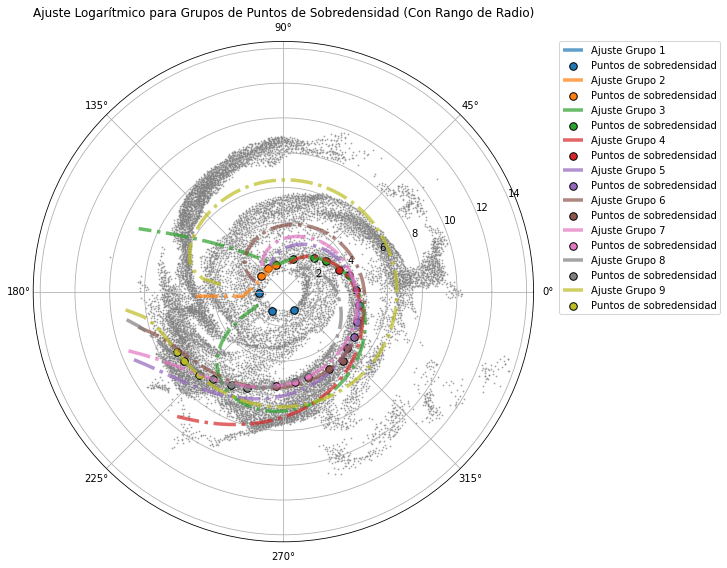

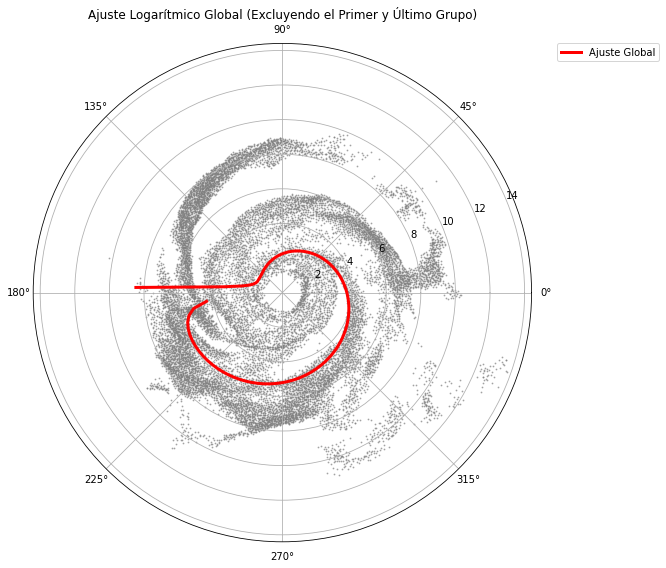

Ajuste Global: A = -1.030445663182945, B = 0.06974937008071613, N = 0.06974937008072146, R^2 = 0.6008


In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import BayesianRidge

# Definir la función logarítmica de la espiral incluyendo A, B y N
def log_spiral(phi, A, B, N):
    """
    r(φ) = A / log(B * tan(φ / 2N))
    """
    safe_phi = np.clip(phi, 1e-6, None)  # Evitar valores problemáticos para tan y log
    return A / np.log(B * np.tan(safe_phi / (2 * N)) + 1e-6)

# Clase para crear un ajuste Bayesiano
class BayesianSpiralFitter:
    def __init__(self, alpha_1=1e-6, lambda_1=1e-6):
        self.bayesian_ridge = BayesianRidge(alpha_1=alpha_1, lambda_1=lambda_1)
        self.A_ = None
        self.B_ = None
        self.N_ = None
        self.r2_score_ = None

    def fit(self, phi, r):
        # Preprocesar los valores de phi, ahora con tres características: φ, tan(φ/2), tan(φ/2N)
        X = np.column_stack([phi, np.tan(phi / 2), np.tan(phi / 2)])
        self.bayesian_ridge.fit(X, r)
        # Obtener los coeficientes ajustados
        self.A_ = self.bayesian_ridge.coef_[0]
        self.B_ = self.bayesian_ridge.coef_[1]
        self.N_ = self.bayesian_ridge.coef_[2]
        # Calcular el score R^2 para este ajuste
        self.r2_score_ = self.bayesian_ridge.score(X, r)
        return self.r2_score_

    def predict(self, phi, r_min, r_max):
        """
        Predecir los valores de r para un rango de φ dentro de r_min y r_max.
        Filtra los valores de r fuera del rango dado.
        """
        X = np.column_stack([phi, np.tan(phi / 2), np.tan(phi / 2)])
        r_pred = self.bayesian_ridge.predict(X)
        
        # Aplicar el filtro de r_min y r_max
        mask = (r_pred >= r_min) & (r_pred <= r_max)
        return r_pred[mask], phi[mask]  # Devuelve los valores de r y phi filtrados

# Función para convertir de coordenadas cartesianas a polares
def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return r, phi

# Cargar los datos
data_arm = pd.read_csv('../DATA/processed/TracingPoints/arm_tracing_11_arm1_rho_dani.csv')

# Extraer los valores de x e y
x_values = data_arm['x'].values
y_values = data_arm['y'].values

# Convertir a coordenadas polares
r_values, phi_values = cartesian_to_polar(x_values, y_values)

# Función para dividir los puntos en subconjuntos de 3 en 3
def divide_points_in_groups(r_values, phi_values, group_size=3):
    for i in range(0, len(r_values), group_size):
        yield r_values[i:i+group_size], phi_values[i:i+group_size]

# Definir los límites de radio para los ajustes
r_min = np.percentile(r_values_sorted, 2.5)  # 5% más cercano al centro
r_max = np.percentile(r_values_sorted, 97.5)  # 95% más lejano al borde

# Lista para almacenar los valores de los ajustes y estadísticas
adjustment_info = []

# Ajustar y graficar para cada grupo de 3 puntos, excluyendo el primero y último grupo
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))

# Graficar los puntos originales
ax.scatter(phi_values_sorted, r_values_sorted, s=0.7, alpha=0.6, c='gray')

# Almacenar los puntos para el ajuste global (excluyendo el primer y último grupo)
r_values_for_global = []
phi_values_for_global = []

# Ajustar para cada conjunto de tres puntos, excluyendo el primero y el último
for group_index, (r_group, phi_group) in enumerate(divide_points_in_groups(r_values, phi_values)):
    if len(r_group) < 3:  # Asegurarnos de que haya 3 puntos en el grupo
        continue

    # Omitir el primer y el último grupo
    if group_index == 0 or (group_index + 1) * 3 >= len(r_values):
        continue

    # Guardar los valores de r y phi para el ajuste global
    r_values_for_global.extend(r_group)
    phi_values_for_global.extend(phi_group)

    # Ajuste bayesiano para este subconjunto
    bayesian_spiral = BayesianSpiralFitter()
    r2_score = bayesian_spiral.fit(phi_group, r_group)
    
    # Guardar los valores del ajuste en la lista
    adjustment_info.append({
        'grupo': group_index,
        'A': bayesian_spiral.A_,
        'B': bayesian_spiral.B_,
        'N': bayesian_spiral.N_,
        'r_min': r_min,
        'r_max': r_max,
        'phi_group': phi_group,
        'r_group': r_group,
        'r2_score': r2_score  # Guardar el score R^2
    })
    
    # Predecir los valores ajustados para todo el rango global de φ dentro del rango [r_min, r_max]
    phi_fit = np.linspace(np.min(phi_values), np.max(phi_values), 100)  # Usar el phi global
    r_fit, phi_fit_filtered = bayesian_spiral.predict(phi_fit, r_min, r_max)
    
    # Graficar el ajuste para este subconjunto
    ax.plot(phi_fit_filtered, r_fit, '-.', label=f'Ajuste Grupo {group_index}', linewidth=3.5, alpha=0.7)
    ax.scatter(phi_group, r_group, label='Puntos de sobredensidad', edgecolor='black', s=57)

# Ajustar leyenda y moverla fuera de la gráfica
ax.set_title('Ajuste Logarítmico para Grupos de Puntos de Sobredensidad (Con Rango de Radio)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# Ajuste Global (para todos los puntos, menos el primer y último grupo)
# Convertir a numpy arrays para el ajuste global
r_values_for_global = np.array(r_values_for_global)
phi_values_for_global = np.array(phi_values_for_global)

# Realizar el ajuste global con todos los puntos
bayesian_spiral_global = BayesianSpiralFitter()
r2_score_global = bayesian_spiral_global.fit(phi_values_for_global, r_values_for_global)

# Predecir los valores ajustados para todo el rango global de φ dentro del rango [r_min, r_max]
phi_fit_global = np.linspace(np.min(phi_values), np.max(phi_values), 100)
r_fit_global, phi_fit_filtered_global = bayesian_spiral_global.predict(phi_fit_global, r_min, r_max)

# Graficar el ajuste global
fig, ax_global = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))
ax_global.plot(phi_fit_filtered_global, r_fit_global, label='Ajuste Global', color='red', linewidth=3)
ax_global.scatter(phi_values_sorted, r_values_sorted, s=0.7, alpha=0.6, c='gray')
ax_global.set_title('Ajuste Logarítmico Global (Excluyendo el Primer y Último Grupo)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()

# Mostrar el gráfico global
plt.show()

# Mostrar los valores de ajuste global
print(f"Ajuste Global: A = {bayesian_spiral_global.A_}, B = {bayesian_spiral_global.B_}, N = {bayesian_spiral_global.N_}, R^2 = {r2_score_global:.4f}")



In [60]:
# Mostrar los valores de ajuste almacenados
for adjustment in adjustment_info:
    print(f"Grupo: {adjustment['grupo']}, A: {adjustment['A']}, B: {adjustment['B']}, N: {adjustment['N']}, R^2: {adjustment['r2_score']:.4f}")


Grupo: 1, A: -0.04554300048861058, B: -0.0005767136535506307, N: -0.0005767136535506307, R^2: 1.0000
Grupo: 2, A: 0.34666173679792944, B: -0.06500197074830302, N: -0.06500197074830302, R^2: 1.0000
Grupo: 3, A: -3.5886680354432663, B: 1.5203860675557603, N: 1.5203860675557603, R^2: 1.0000
Grupo: 4, A: -1.1554431650692538, B: -0.6005033359601774, N: -0.6005033359601774, R^2: 0.8919
Grupo: 5, A: -0.6487091025269099, B: -0.3771645714060246, N: -0.3771645714060246, R^2: 0.9657
Grupo: 6, A: -0.3123227121574796, B: -0.18252241628735869, N: -0.18252241628735869, R^2: 0.4898
Grupo: 7, A: -0.16747348111814858, B: -0.4504023383582848, N: -0.4504023383582848, R^2: 0.9880
Grupo: 8, A: -1.3426505386566614, B: -0.09558675800310645, N: -0.09558675800310645, R^2: 1.0000
Grupo: 9, A: 0.032917424507592274, B: -0.0777750598349223, N: -0.0777750598349223, R^2: 1.0000


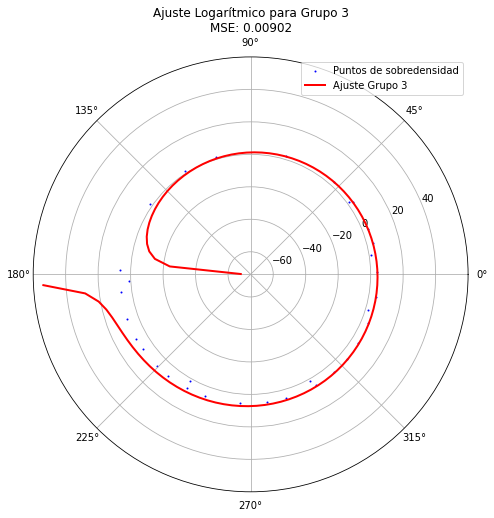

Los ajustes y estadísticas han sido almacenados en 'ajustes_log_spiral.csv'


In [37]:
plot_adjustment(3)

# Almacenar los ajustes y estadísticas en un archivo CSV
adjustments_df = pd.DataFrame({
    'group_index': [adj['group_index'] for adj in adjustments],
    'A': [adj['A'] for adj in adjustments],
    'B': [adj['B'] for adj in adjustments],
    'N': [adj['N'] for adj in adjustments],
    'mse': [adj['mse'] for adj in adjustments]
})
adjustments_df.to_csv('ajustes_log_spiral.csv', index=False)
print("Los ajustes y estadísticas han sido almacenados en 'ajustes_log_spiral.csv'")


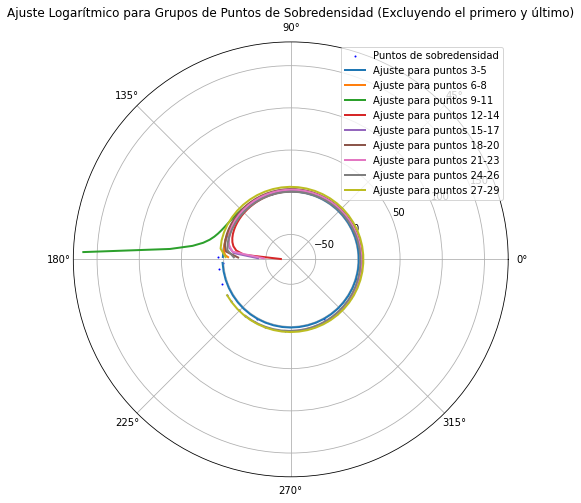

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import BayesianRidge

# Definir la función logarítmica de la espiral incluyendo A, B y N
def log_spiral(phi, A, B, N):
    """
    r(φ) = A / log(B * tan(φ / 2N))
    """
    safe_phi = np.clip(phi, 1e-6, None)  # Evitar valores problemáticos para tan y log
    return A / np.log(B * np.tan(safe_phi / (2 * N)) + 1e-6)

# Crear un ajuste Bayesiano
class BayesianSpiralFitter:
    def __init__(self, alpha_1=1e-6, lambda_1=1e-6):
        self.bayesian_ridge = BayesianRidge(alpha_1=alpha_1, lambda_1=lambda_1)
        self.A_ = None
        self.B_ = None
        self.N_ = None

    def fit(self, phi, r):
        # Preprocesar los valores de phi, ahora con tres características: φ, tan(φ/2) y tan(φ/2N)
        X = np.column_stack([phi, np.tan(phi / 2), np.tan(phi / 2)])  # Crear tres características
        self.bayesian_ridge.fit(X, r)
        # Obtener los coeficientes ajustados
        self.A_ = self.bayesian_ridge.coef_[0]
        self.B_ = self.bayesian_ridge.coef_[1]
        self.N_ = self.bayesian_ridge.coef_[2]

    def predict(self, phi):
        # Preprocesar phi
        X = np.column_stack([phi, np.tan(phi / 2), np.tan(phi / 2)])
        return self.bayesian_ridge.predict(X)

# Función para convertir de coordenadas cartesianas a polares
def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return r, phi

# Cargar los datos
data_arm = pd.read_csv('../DATA/processed/TracingPoints/arm_tracing_11_arm1_rho_dani.csv')

# Extraer los valores de x e y
x_values = data_arm['x'].values
y_values = data_arm['y'].values

# Convertir a coordenadas polares
r_values, phi_values = cartesian_to_polar(x_values, y_values)

# Función para dividir los puntos en subconjuntos de 3 en 3
def divide_points_in_groups(r_values, phi_values, group_size=3):
    for i in range(0, len(r_values), group_size):
        yield r_values[i:i+group_size], phi_values[i:i+group_size]

# Ajustar y graficar para cada grupo de 3 puntos de manera independiente
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))

# Graficar los puntos originales
ax.scatter(phi_values, r_values, color='blue', label='Puntos de sobredensidad', s=1)

# Ajustar para cada conjunto de tres puntos, a partir del segundo grupo hasta el penúltimo
for group_index, (r_group, phi_group) in enumerate(divide_points_in_groups(r_values, phi_values)):
    if len(r_group) < 3:  # Asegurarnos de que haya 3 puntos en el grupo
        continue

    # Omitir el primer y el último grupo
    if group_index == 0 or (group_index + 1) * 3 >= len(r_values):
        continue

    # Ajuste bayesiano para este subconjunto
    bayesian_spiral = BayesianSpiralFitter()
    bayesian_spiral.fit(phi_group, r_group)
    
    # Predecir los valores ajustados para este grupo
    phi_fit = np.linspace(np.min(phi_group), np.max(phi_values), 50)
    r_fit = bayesian_spiral.predict(phi_fit)
    
    # Graficar el ajuste para este subconjunto
    ax.plot(phi_fit, r_fit, label=f'Ajuste para puntos {group_index * 3}-{group_index * 3 + 2}', linewidth=2)

# Graficar solo desde el segundo grupo hasta el penúltimo
ax.set_title('Ajuste Logarítmico para Grupos de Puntos de Sobredensidad (Excluyendo el primero y último)')
plt.legend()
plt.show()


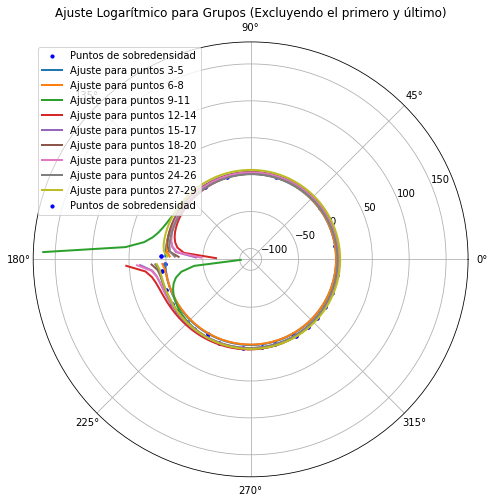

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import BayesianRidge

# Definir la función logarítmica de la espiral incluyendo A, B y N
def log_spiral(phi, A, B, N):
    """
    r(φ) = A / log(B * tan(φ / 2N))
    """
    safe_phi = np.clip(phi, 1e-6, None)  # Evitar valores problemáticos para tan y log
    return A / np.log(B * np.tan(safe_phi / (2 * N)) + 1e-6)

# Crear un ajuste Bayesiano
class BayesianSpiralFitter:
    def __init__(self, alpha_1=1e-6, lambda_1=1e-6):
        self.bayesian_ridge = BayesianRidge(alpha_1=alpha_1, lambda_1=lambda_1)
        self.A_ = None
        self.B_ = None
        self.N_ = None

    def fit(self, phi, r):
        # Preprocesar los valores de phi
        X = np.column_stack([phi, np.tan(phi / 2), np.tan(phi / 2)])  # Crear tres características
        self.bayesian_ridge.fit(X, r)
        # Obtener los coeficientes ajustados
        self.A_ = self.bayesian_ridge.coef_[0]
        self.B_ = self.bayesian_ridge.coef_[1]
        self.N_ = self.bayesian_ridge.coef_[2]

    def predict(self, phi):
        # Preprocesar phi
        X = np.column_stack([phi, np.tan(phi / 2), np.tan(phi / 2)])
        return self.bayesian_ridge.predict(X)

# Función para convertir de coordenadas cartesianas a polares
def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return r, phi

# Cargar los datos
data_arm = pd.read_csv('../DATA/processed/TracingPoints/arm_tracing_11_arm1_rho_dani.csv')

# Extraer los valores de x e y
x_values = data_arm['x'].values
y_values = data_arm['y'].values

# Convertir a coordenadas polares
r_values, phi_values = cartesian_to_polar(x_values, y_values)

# Función para dividir los puntos en subconjuntos de 3 en 3
def divide_points_in_groups(r_values, phi_values, group_size=3):
    for i in range(0, len(r_values), group_size):
        yield r_values[i:i+group_size], phi_values[i:i+group_size]

# Ajustar y graficar para cada grupo de 3 puntos, pero predecir para todo el rango global de phi
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))

# Graficar los puntos originales
ax.scatter(phi_values, r_values, color='blue', label='Puntos de sobredensidad', s=10)

# Ajustar para cada conjunto de tres puntos, pero graficar para todo el rango de φ global
for group_index, (r_group, phi_group) in enumerate(divide_points_in_groups(r_values, phi_values)):
    if len(r_group) < 3:  # Asegurarnos de que haya 3 puntos en el grupo
        continue

    # Omitir el primer y el último grupo
    if group_index == 0 or (group_index + 1) * 3 >= len(r_values):
        continue

    # Ajuste bayesiano para este subconjunto
    bayesian_spiral = BayesianSpiralFitter()
    bayesian_spiral.fit(phi_group, r_group)
    
    # Predecir los valores ajustados para todo el rango global de φ y r (excluyendo el primer y último grupo)
    phi_fit = np.linspace(np.min(phi_values), np.max(phi_values), 100)  # Usar el phi global
    r_fit = bayesian_spiral.predict(phi_fit)
    
    # Graficar el ajuste sobre todos los valores globales
    ax.plot(phi_fit, r_fit, label=f'Ajuste para puntos {group_index * 3}-{group_index * 3 + 2}', linewidth=2)
ax.scatter(phi_values, r_values, color='blue', label='Puntos de sobredensidad', s=10)

ax.set_title('Ajuste Logarítmico para Grupos (Excluyendo el primero y último)')
plt.legend()
plt.show()


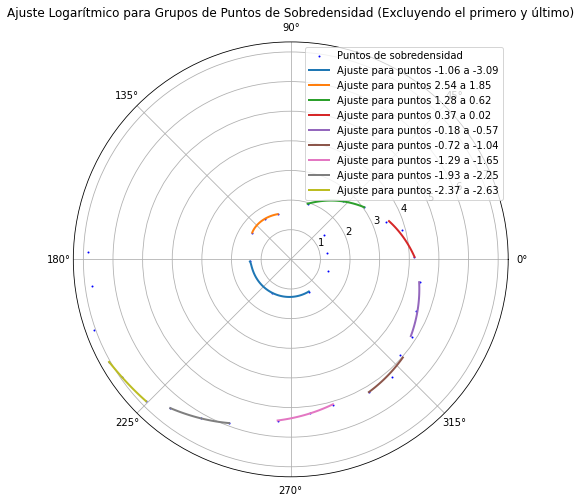

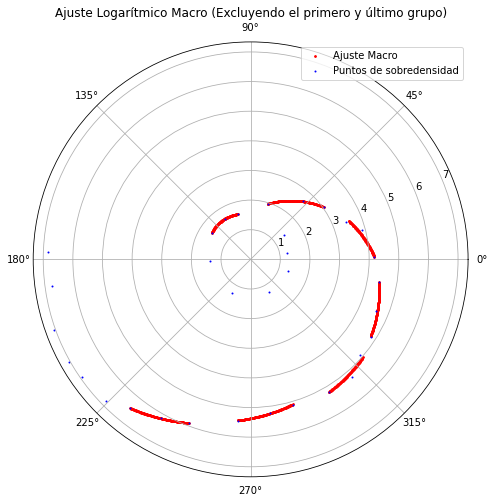

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import BayesianRidge

# Definir la función logarítmica de la espiral incluyendo A, B y N
def log_spiral(phi, A, B, N):
    """
    r(φ) = A / log(B * tan(φ / 2N))
    """
    safe_phi = np.clip(phi, 1e-6, None)  # Evitar valores problemáticos para tan y log
    return A / np.log(B * np.tan(safe_phi / (2 * N)) + 1e-6)

# Crear un ajuste Bayesiano
class BayesianSpiralFitter:
    def __init__(self, alpha_1=1e-6, lambda_1=1e-6):
        self.bayesian_ridge = BayesianRidge(alpha_1=alpha_1, lambda_1=lambda_1)
        self.A_ = None
        self.B_ = None
        self.N_ = None

    def fit(self, phi, r):
        # Preprocesar los valores de phi, ahora con tres características: φ, tan(φ/2) y tan(φ/2N)
        X = np.column_stack([phi, np.tan(phi / 2), np.tan(phi / 2)])  # Crear tres características
        self.bayesian_ridge.fit(X, r)
        # Obtener los coeficientes ajustados
        self.A_ = self.bayesian_ridge.coef_[0]
        self.B_ = self.bayesian_ridge.coef_[1]
        self.N_ = self.bayesian_ridge.coef_[2]

    def predict(self, phi):
        # Preprocesar phi
        X = np.column_stack([phi, np.tan(phi / 2), np.tan(phi / 2)])
        return self.bayesian_ridge.predict(X)

# Función para convertir de coordenadas cartesianas a polares
def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return r, phi

# Cargar los datos
data_arm = pd.read_csv('../DATA/processed/TracingPoints/arm_tracing_11_arm1_rho_dani.csv')

# Extraer los valores de x e y
x_values = data_arm['x'].values
y_values = data_arm['y'].values

# Convertir a coordenadas polares
r_values, phi_values = cartesian_to_polar(x_values, y_values)

# Función para dividir los puntos en subconjuntos de 3 en 3
def divide_points_in_groups(r_values, phi_values, group_size=3):
    for i in range(0, len(r_values), group_size):
        yield r_values[i:i+group_size], phi_values[i:i+group_size]

# Ajustar y graficar para cada grupo de 3 puntos
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))

# Graficar los puntos originales
ax.scatter(phi_values, r_values, color='blue', label='Puntos de sobredensidad', s=1)

# Almacenar los ajustes intermedios (sin el primer y último grupo)
intermediate_fits = []

# Ajustar para cada conjunto de tres puntos, excluyendo el primero y el último
for group_index, (r_group, phi_group) in enumerate(divide_points_in_groups(r_values, phi_values)):
    if len(r_group) < 3:  # Asegurarnos de que haya 3 puntos en el grupo
        continue

    # Omitir el primer y el último grupo
    if group_index == 0 or (group_index + 1) * 3 >= len(r_values):
        continue

    # Ajuste bayesiano para este subconjunto
    bayesian_spiral = BayesianSpiralFitter()
    bayesian_spiral.fit(phi_group, r_group)
    
    # Predecir los valores ajustados para este grupo
    phi_fit = np.linspace(np.min(phi_group), np.max(phi_group), 100)
    r_fit = bayesian_spiral.predict(phi_fit)
    
    # Almacenar los ajustes intermedios
    intermediate_fits.append((phi_fit, r_fit))
    
    # Graficar el ajuste para este subconjunto
    ax.plot(phi_fit, r_fit, label=f'Ajuste para puntos {phi_group[0]:.2f} a {phi_group[-1]:.2f}', linewidth=2)

ax.set_title('Ajuste Logarítmico para Grupos de Puntos de Sobredensidad (Excluyendo el primero y último)')
plt.legend()
plt.show()

# AJUSTE MACRO
# Ahora concatenamos solo los valores ajustados de los grupos intermedios (no el primero ni el último)

# Concatenar solo los phi y r ajustados de los grupos intermedios
all_phi_fit = np.concatenate([phi_fit for group_index, (phi_fit, r_fit) in enumerate(intermediate_fits)
                              if group_index != 0 and group_index != len(intermediate_fits)-1])
all_r_fit = np.concatenate([r_fit for group_index, (phi_fit, r_fit) in enumerate(intermediate_fits)
                            if group_index != 0 and group_index != len(intermediate_fits)-1])

# Graficar el ajuste macro con los puntos de sobredensidad
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))
ax.scatter(all_phi_fit, all_r_fit, label='Ajuste Macro', color='red', s=3)
ax.scatter(phi_values, r_values, color='blue', label='Puntos de sobredensidad', s=1)
ax.set_title('Ajuste Logarítmico Macro (Excluyendo el primero y último grupo)')
plt.legend()
plt.show()


In [40]:
# Load the data
data_arm = pd.read_csv('../DATA/processed/TracingPoints/arm_tracing_11_arm1_rho_dani.csv')

# Extract x and y values
x_values = data_arm['x'].values
y_values = data_arm['y'].values


x_values_s = sorted_data['x'].values
y_values_s = sorted_data['y'].values


# Convert to polar coordinates
r_values, phi_values = cartesian_to_polar(x_values, y_values)
r_values_s, phi_values_s = cartesian_to_polar(x_values_s, y_values_s)


array([ 0.63647752,  0.16162136, -0.29303782, -1.05941988, -2.08713773,
       -3.08951963,  2.53502624,  2.13758306,  1.85351748,  1.27594951,
        0.83267124,  0.617223  ,  0.37114679,  0.2546952 ,  0.02021999,
       -0.17593359, -0.39151828, -0.56852455, -0.7191105 , -0.86030311,
       -1.0386205 , -1.28758399, -1.44629657, -1.65195843, -1.93070128,
       -2.08229197, -2.25165934, -2.3663918 , -2.53370934, -2.6276584 ,
       -2.79859195, -3.00983683,  3.10650371])

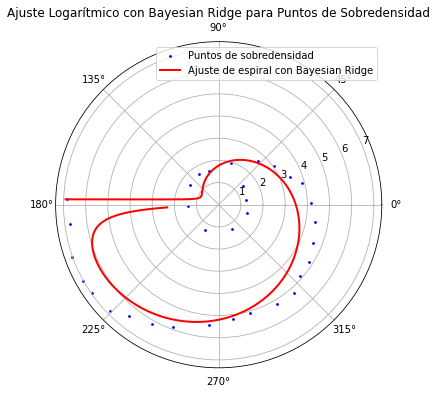

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import BayesianRidge

# Definir la función logarítmica de la espiral
def log_spiral(phi, B, N):
    """
    r(φ) = A / log(B * tan(φ / 2N))
    Suponemos A = 1 para simplificar
    """
    safe_phi = np.clip(phi, 1e-6, None)  # Evitar log(0) o valores negativos
    return 1 / np.log(B * np.tan(safe_phi / (2 * N)) + 1e-6)

# Crear un ajuste Bayesiano
class BayesianSpiralFitter:
    def __init__(self, alpha_1=1e-6, lambda_1=1e-6):
        self.bayesian_ridge = BayesianRidge(alpha_1=alpha_1, lambda_1=lambda_1)
        self.B_ = None
        self.N_ = None

    def fit(self, phi, r):
        # Preprocesar los valores de phi
        X = np.column_stack([phi, np.tan(phi / 2)])  # Crear características basadas en φ y tan(φ / 2)
        self.bayesian_ridge.fit(X, r)
        # Obtener los coeficientes ajustados
        self.B_ = self.bayesian_ridge.coef_[0]
        self.N_ = self.bayesian_ridge.coef_[1]

    def predict(self, phi):
        # Preprocesar phi
        X = np.column_stack([phi, np.tan(phi / 2)])
        return self.bayesian_ridge.predict(X)

# Función para convertir de coordenadas cartesianas a polares
def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return r, phi

# Cargar los datos
data_arm = pd.read_csv('../DATA/processed/TracingPoints/arm_tracing_11_arm1_rho_dani.csv')

# Extraer los valores de x e y
x_values = data_arm['x'].values
y_values = data_arm['y'].values

# Convertir a coordenadas polares
r_values, phi_values = cartesian_to_polar(x_values, y_values)

# Ajustar el modelo bayesiano
bayesian_spiral = BayesianSpiralFitter()
bayesian_spiral.fit(phi_values, r_values)

# Predecir los valores ajustados
phi_fit = np.linspace(np.min(phi_values), np.max(phi_values), 1000)
r_fit = bayesian_spiral.predict(phi_fit)

# Graficar los resultados
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))

# Graficar los puntos originales
ax.scatter(phi_values, r_values, color='blue', label='Puntos de sobredensidad', s=3)

# Graficar el ajuste de la espiral
ax.plot(phi_fit, r_fit, label='Ajuste de espiral con Bayesian Ridge', color='red', linewidth=2)

ax.set_title('Ajuste Logarítmico con Bayesian Ridge para Puntos de Sobredensidad')
plt.legend()
plt.show()


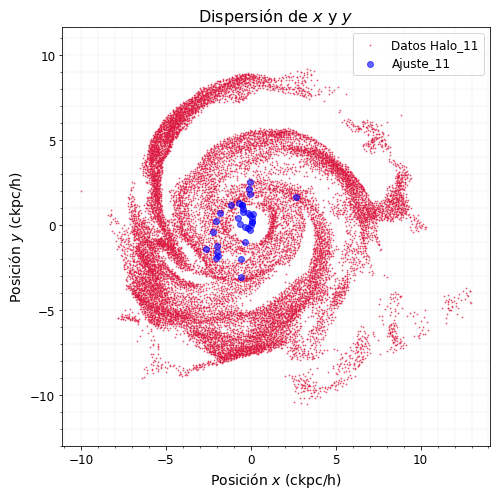

In [25]:
x_polar,y_polar = polar_to_cartesian(phi_values, r_values)


# Figura x,y halo
fig, ax = plt.subplots(figsize=(7, 7))

scatter = ax.scatter(x_values_s, y_values_s, c=h_alpha_color, s=0.7, alpha=0.6, label=f'Datos Halo_{id_halo}')
plot = ax.scatter(x_polar,y_polar, c='b', alpha=0.6, label=f'Ajuste_{id_halo}')

ax.set_title(r'Dispersión de $x$ y $y$', fontsize=16)
ax.set_xlabel(r'Posición $x$ (ckpc/h)', fontsize=14)
ax.set_ylabel(r'Posición $y$ (ckpc/h)', fontsize=14)
ax.legend(loc='best', fontsize=12)

ax.grid(True, which='both', linestyle='--', linewidth=0.4, alpha=0.4)
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.axis('equal')

plt.tight_layout()
plt.show()


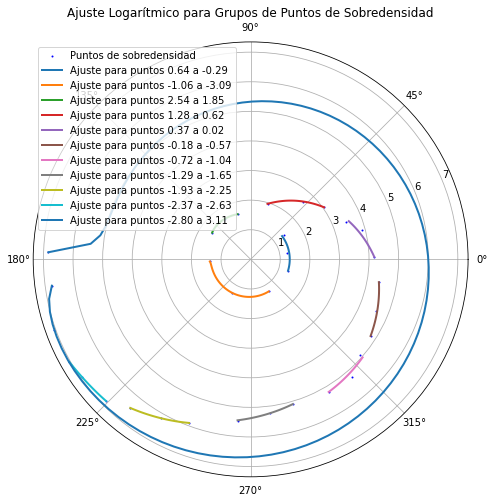

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import BayesianRidge

# Definir la función logarítmica de la espiral incluyendo A, B y N
def log_spiral(phi, A, B, N):
    """
    r(φ) = A / log(B * tan(φ / 2N))
    """
    safe_phi = np.clip(phi, 1e-6, None)  # Evitar valores problemáticos para tan y log
    return A / np.log(B * np.tan(safe_phi / (2 * N)) + 1e-6)

# Crear un ajuste Bayesiano
class BayesianSpiralFitter:
    def __init__(self, alpha_1=1e-6, lambda_1=1e-6):
        self.bayesian_ridge = BayesianRidge(alpha_1=alpha_1, lambda_1=lambda_1)
        self.A_ = None
        self.B_ = None
        self.N_ = None

    def fit(self, phi, r):
        # Preprocesar los valores de phi, ahora con tres características: φ, tan(φ/2) y tan(φ/2N)
        X = np.column_stack([phi, np.tan(phi / 2), np.tan(phi / 2)])  # Crear tres características
        self.bayesian_ridge.fit(X, r)
        # Obtener los coeficientes ajustados
        self.A_ = self.bayesian_ridge.coef_[0]
        self.B_ = self.bayesian_ridge.coef_[1]
        self.N_ = self.bayesian_ridge.coef_[2]

    def predict(self, phi):
        # Preprocesar phi
        X = np.column_stack([phi, np.tan(phi / 2), np.tan(phi / 2)])
        return self.bayesian_ridge.predict(X)

# Función para convertir de coordenadas cartesianas a polares
def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return r, phi

# Cargar los datos
data_arm = pd.read_csv('../DATA/processed/TracingPoints/arm_tracing_11_arm1_rho_dani.csv')

# Extraer los valores de x e y
x_values = data_arm['x'].values
y_values = data_arm['y'].values

# Convertir a coordenadas polares
r_values, phi_values = cartesian_to_polar(x_values, y_values)

# Función para dividir los puntos en subconjuntos de 3 en 3
def divide_points_in_groups(r_values, phi_values, group_size=3):
    for i in range(0, len(r_values), group_size):
        yield r_values[i:i+group_size], phi_values[i:i+group_size]

# Ajustar y graficar para cada grupo de 3 puntos
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))

# Graficar los puntos originales
ax.scatter(phi_values, r_values, color='blue', label='Puntos de sobredensidad', s=1)

# Ajustar para cada conjunto de tres puntos
for r_group, phi_group in divide_points_in_groups(r_values, phi_values):
    if len(r_group) < 3:  # Asegurarnos de que haya 3 puntos en el grupo
        continue
    
    # Ajuste bayesiano para este subconjunto
    bayesian_spiral = BayesianSpiralFitter()
    bayesian_spiral.fit(phi_group, r_group)
    
    # Predecir los valores ajustados para este grupo
    phi_fit = np.linspace(np.min(phi_group), np.max(phi_group), 100)
    r_fit = bayesian_spiral.predict(phi_fit)
    
    # Graficar el ajuste para este subconjunto
    ax.plot(phi_fit, r_fit, label=f'Ajuste para puntos {phi_group[0]:.2f} a {phi_group[-1]:.2f}', linewidth=2)

ax.set_title('Ajuste Logarítmico para Grupos de Puntos de Sobredensidad')
plt.legend()
plt.show()


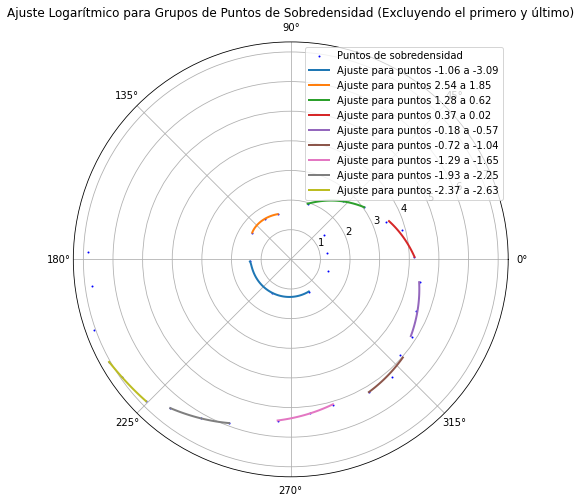

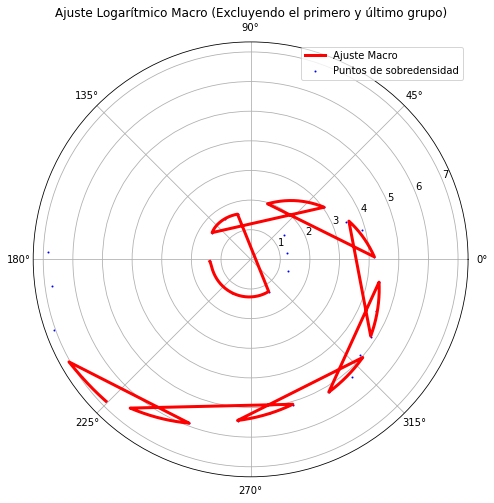

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import BayesianRidge

# Definir la función logarítmica de la espiral incluyendo A, B y N
def log_spiral(phi, A, B, N):
    """
    r(φ) = A / log(B * tan(φ / 2N))
    """
    safe_phi = np.clip(phi, 1e-6, None)  # Evitar valores problemáticos para tan y log
    return A / np.log(B * np.tan(safe_phi / (2 * N)) + 1e-6)

# Crear un ajuste Bayesiano
class BayesianSpiralFitter:
    def __init__(self, alpha_1=1e-6, lambda_1=1e-6):
        self.bayesian_ridge = BayesianRidge(alpha_1=alpha_1, lambda_1=lambda_1)
        self.A_ = None
        self.B_ = None
        self.N_ = None

    def fit(self, phi, r):
        # Preprocesar los valores de phi, ahora con tres características: φ, tan(φ/2) y tan(φ/2N)
        X = np.column_stack([phi, np.tan(phi / 2), np.tan(phi / 2)])  # Crear tres características
        self.bayesian_ridge.fit(X, r)
        # Obtener los coeficientes ajustados
        self.A_ = self.bayesian_ridge.coef_[0]
        self.B_ = self.bayesian_ridge.coef_[1]
        self.N_ = self.bayesian_ridge.coef_[2]

    def predict(self, phi):
        # Preprocesar phi
        X = np.column_stack([phi, np.tan(phi / 2), np.tan(phi / 2)])
        return self.bayesian_ridge.predict(X)

# Función para convertir de coordenadas cartesianas a polares
def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return r, phi

# Cargar los datos
data_arm = pd.read_csv('../DATA/processed/TracingPoints/arm_tracing_11_arm1_rho_dani.csv')

# Extraer los valores de x e y
x_values = data_arm['x'].values
y_values = data_arm['y'].values

# Convertir a coordenadas polares
r_values, phi_values = cartesian_to_polar(x_values, y_values)

# Función para dividir los puntos en subconjuntos de 3 en 3
def divide_points_in_groups(r_values, phi_values, group_size=3):
    for i in range(0, len(r_values), group_size):
        yield r_values[i:i+group_size], phi_values[i:i+group_size]

# Ajustar y graficar para cada grupo de 3 puntos
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))

# Graficar los puntos originales
ax.scatter(phi_values, r_values, color='blue', label='Puntos de sobredensidad', s=1)

# Almacenar los ajustes intermedios (sin el primer y último grupo)
intermediate_fits = []

# Ajustar para cada conjunto de tres puntos, excluyendo el primero y el último
for group_index, (r_group, phi_group) in enumerate(divide_points_in_groups(r_values, phi_values)):
    if len(r_group) < 3:  # Asegurarnos de que haya 3 puntos en el grupo
        continue

    # Omitir el primer y el último grupo
    if group_index == 0 or (group_index + 1) * 3 >= len(r_values):
        continue

    # Ajuste bayesiano para este subconjunto
    bayesian_spiral = BayesianSpiralFitter()
    bayesian_spiral.fit(phi_group, r_group)
    
    # Predecir los valores ajustados para este grupo
    phi_fit = np.linspace(np.min(phi_group), np.max(phi_group), 100)
    r_fit = bayesian_spiral.predict(phi_fit)
    
    # Almacenar los ajustes intermedios
    intermediate_fits.append((phi_fit, r_fit))
    
    # Graficar el ajuste para este subconjunto
    ax.plot(phi_fit, r_fit, label=f'Ajuste para puntos {phi_group[0]:.2f} a {phi_group[-1]:.2f}', linewidth=2)

ax.set_title('Ajuste Logarítmico para Grupos de Puntos de Sobredensidad (Excluyendo el primero y último)')
plt.legend()
plt.show()

# AJUSTE MACRO
# Unir los resultados intermedios para hacer un ajuste macro
all_phi_fit = np.concatenate([phi_fit for phi_fit, r_fit in intermediate_fits])
all_r_fit = np.concatenate([r_fit for phi_fit, r_fit in intermediate_fits])

# Graficar el ajuste macro
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))
ax.plot(all_phi_fit, all_r_fit, label='Ajuste Macro', color='red', linewidth=3)
ax.scatter(phi_values, r_values, color='blue', label='Puntos de sobredensidad', s=1)
ax.set_title('Ajuste Logarítmico Macro (Excluyendo el primero y último grupo)')
plt.legend()
plt.show()


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in log
/home/daniel/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


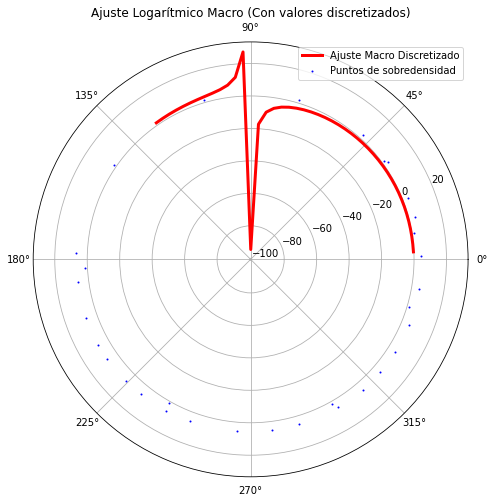

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import BayesianRidge

# Definir la función logarítmica de la espiral incluyendo A, B y N
def log_spiral(phi, A, B, N):
    """
    r(φ) = A / log(B * tan(φ / 2N))
    """
    safe_phi = np.clip(phi, 1e-6, None)  # Evitar valores problemáticos para tan y log
    return A / np.log(B * np.tan(safe_phi / (2 * N)) + 1e-6)

# Crear un ajuste Bayesiano
class BayesianSpiralFitter:
    def __init__(self, alpha_1=1e-6, lambda_1=1e-6):
        self.bayesian_ridge = BayesianRidge(alpha_1=alpha_1, lambda_1=lambda_1)
        self.A_ = None
        self.B_ = None
        self.N_ = None

    def fit(self, phi, r):
        # Preprocesar los valores de phi, ahora con tres características: φ, tan(φ/2) y tan(φ/2N)
        X = np.column_stack([phi, np.tan(phi / 2), np.tan(phi / 2)])  # Crear tres características
        self.bayesian_ridge.fit(X, r)
        # Obtener los coeficientes ajustados
        self.A_ = self.bayesian_ridge.coef_[0]
        self.B_ = self.bayesian_ridge.coef_[1]
        self.N_ = self.bayesian_ridge.coef_[2]

    def predict(self, phi):
        # Preprocesar phi
        X = np.column_stack([phi, np.tan(phi / 2), np.tan(phi / 2)])
        return self.bayesian_ridge.predict(X)

# Función para convertir de coordenadas cartesianas a polares
def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return r, phi

# Cargar los datos
data_arm = pd.read_csv('../DATA/processed/TracingPoints/arm_tracing_11_arm1_rho_dani.csv')

# Extraer los valores de x e y
x_values = data_arm['x'].values
y_values = data_arm['y'].values

# Convertir a coordenadas polares
r_values, phi_values = cartesian_to_polar(x_values, y_values)

# Función para dividir los puntos en subconjuntos de 3 en 3
def divide_points_in_groups(r_values, phi_values, group_size=3):
    for i in range(0, len(r_values), group_size):
        yield r_values[i:i+group_size], phi_values[i:i+group_size]

# Almacenar los ajustes discretizados
discrete_adjustments_r = []
discrete_adjustments_phi = []

# Ajustar para cada conjunto de tres puntos, excluyendo el primero y el último
for group_index, (r_group, phi_group) in enumerate(divide_points_in_groups(r_values, phi_values)):
    if len(r_group) < 3:  # Asegurarnos de que haya 3 puntos en el grupo
        continue

    # Omitir el primer y el último grupo
    if group_index == 0 or (group_index + 1) * 3 >= len(r_values):
        continue

    # Ajuste bayesiano para este subconjunto
    bayesian_spiral = BayesianSpiralFitter()
    bayesian_spiral.fit(phi_group, r_group)
    
    # Predecir los valores ajustados para este grupo
    phi_fit = np.linspace(np.min(phi_group), np.max(phi_group), 100)
    r_fit = bayesian_spiral.predict(phi_fit)
    
    # Discretizar: Tomar puntos representativos
    discrete_phi = np.mean(phi_group)  # Usar la media de phi como punto representativo
    discrete_r = np.mean(r_fit)  # Usar la media del ajuste r como punto representativo
    
    # Almacenar los valores discretizados
    discrete_adjustments_r.append(discrete_r)
    discrete_adjustments_phi.append(discrete_phi)

# Convertir las listas a arrays
discrete_adjustments_r = np.array(discrete_adjustments_r)
discrete_adjustments_phi = np.array(discrete_adjustments_phi)

# AJUSTE MACRO usando los valores discretizados
def macro_fit(phi, A, B, N):
    return A / np.log(B * np.tan(phi / (2 * N)) + 1e-6)

# Ajuste global con curve_fit para los valores discretizados
initial_guess = [1.0, 1.0, 1.0]  # Adivinanza inicial
macro_params, _ = curve_fit(macro_fit, discrete_adjustments_phi, discrete_adjustments_r, p0=initial_guess)

# Obtener los valores ajustados a partir del ajuste macro
phi_macro = np.linspace(np.min(discrete_adjustments_phi), np.max(discrete_adjustments_phi), 100)
r_macro = macro_fit(phi_macro, *macro_params)

# Graficar el ajuste macro
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))
ax.plot(phi_macro, r_macro, label='Ajuste Macro Discretizado', color='red', linewidth=3)
ax.scatter(phi_values, r_values, color='blue', label='Puntos de sobredensidad', s=1)
ax.set_title('Ajuste Logarítmico Macro (Con valores discretizados)')
plt.legend()
plt.show()


In [80]:
# Asegurarse de que los valores de phi están en el rango correcto
phi_multiple_points = np.mod(phi_multiple_points, 2*np.pi)
phi_multiple_points

array([0.63647752, 0.16162136, 5.99014749, 5.22376543, 4.19604758,
       3.19366568, 2.53502624, 2.13758306, 1.85351748, 1.27594951,
       0.83267124, 0.617223  , 0.37114679, 0.2546952 , 0.02021999,
       6.10725171, 5.89166703, 5.71466076, 5.56407481, 5.42288219,
       5.24456481, 4.99560132, 4.83688873, 4.63122688, 4.35248403,
       4.20089334, 4.03152597, 3.91679351, 3.74947596, 3.65552691,
       3.48459336, 3.27334848, 3.10650371])

In [82]:
# Filtrar los puntos de sobredensidad, asumiendo que hay un umbral de deltaRho o una condición para los puntos azules
# Ajusta el umbral de densidad de acuerdo a tus datos
sobredensidad_threshold = 0.8 * np.max(r_multiple_points)  # Filtra puntos por densidad

# Filtrar los puntos en función de deltaRho
r_sobredensidad = r_multiple_points[deltaRho > sobredensidad_threshold]
phi_sobredensidad = phi_multiple_points[deltaRho > sobredensidad_threshold]

# Ajustar sobre estos puntos
B_fit, N_fit = fit_log_spiral_multiple_points_iteratively(r_sobredensidad, phi_sobredensidad, initial_guess)




# Visualización mejorada solo con los puntos de sobredensidad
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))
sc = ax.scatter(phi_sobredensidad, r_sobredensidad, c=r_sobredensidad, cmap='plasma', s=20, alpha=0.8, label='Puntos de sobredensidad')
ax.plot(phi_fit, r_fit, label=f'Ajuste logarítmico B={B_fit:.2f}, N={N_fit:.2f}', color='r', linewidth=2)
ax.set_title('Ajuste Logarítmico con Puntos Filtrados de Sobredensidad')
plt.colorbar(sc, label=r'$r \ [\mathrm{kpc}]$')
plt.legend()
plt.show()


NameError: name 'deltaRho' is not defined

Parámetros ajustados para múltiples puntos: B = 0.01, N = 10.0


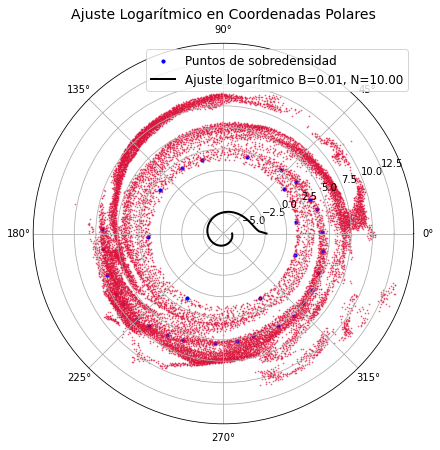

In [59]:
from scipy.optimize import minimize

# Load the data
data_arm = pd.read_csv('../DATA/processed/TracingPoints/arm_tracing_11_arm1_rho_dani.csv')

# Extract x and y values
x_values = data_arm['x'].values
y_values = data_arm['y'].values


x_values_s = sorted_data['x'].values
y_values_s = sorted_data['y'].values


# Convert to polar coordinates
r_values, phi_values = cartesian_to_polar(x_values, y_values)
r_values_s, phi_values_s = cartesian_to_polar(x_values_s, y_values_s)

def log_spiral(phi, B, N):
    A = 30
    # Añadir un factor adicional de suavizado en el ajuste
    safe_phi = np.clip(phi, 1e-6, None)  # Evitar phi negativo o 0
    return 1 *A / (np.log(B * np.tan(safe_phi / (2 * N)) + 1e-6) + 1)  # +1 para evitar valores muy pequeños


def objective(params, phi_values, r_values):
    B, N = params
    r_pred = log_spiral(phi_values, B, N)
    return np.sum((r_pred - r_values)**2)  # Error cuadrático entre el modelo y los datos

def fit_log_spiral_with_minimize(r_values, phi_values, initial_guess):
    result = minimize(objective, initial_guess, args=(phi_values, r_values), bounds=[(0.01, 10.0), (0.01, 10.0)])
    return result.x


# Valores iniciales (r y phi)
r_multiple_points = r_values  # Lista de valores r
phi_multiple_points = phi_values  # Lista de valores phi
initial_guess = [0.5, 4]  # Adivinanza inicial de los parámetros B y N

# Usar la función `minimize` para el ajuste
B_fit, N_fit = fit_log_spiral_with_minimize(r_multiple_points, phi_multiple_points, initial_guess)


# Imprimir los parámetros ajustados
print(f"Parámetros ajustados para múltiples puntos: B = {B_fit}, N = {N_fit}")

# Graficar el ajuste logarítmico en coordenadas polares
phi_fit = np.linspace(0, 2*np.pi, 100)  # Asegurar que cubrimos todo el rango de phi
r_fit = log_spiral(phi_fit, B_fit, N_fit)

# Crear la figura con dos subplots: el ajuste polar y los puntos de sobredensidad
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(7, 7))

# Graficar los puntos de sobredensidad en coordenadas polares
ax.scatter(phi_multiple_points, r_multiple_points, color='blue', s=10, label='Puntos de sobredensidad')
ax.scatter( phi_values_s,r_values_s, c=h_alpha_color, s=0.5, alpha=0.6)

# Graficar el ajuste logarítmico en coordenadas polares
ax.plot(phi_fit, r_fit, color='k', label=f'Ajuste logarítmico B={B_fit:.2f}, N={N_fit:.2f}', lw=2)

# Etiquetas y leyenda
ax.set_title('Ajuste Logarítmico en Coordenadas Polares', fontsize=14)
ax.legend(loc='upper right', fontsize=12)

# Mostrar la gráfica
#plt.tight_layout()
plt.show()




Iteración 1: B = 0.9507305921701783, N = 1.0024410173950238
Iteración 2: B = 0.9507305921701783, N = 1.0024410173950238
Convergencia alcanzada en iteración 2.
Parámetros ajustados finales: B = 0.9507305921701783, N = 1.0024410173950238


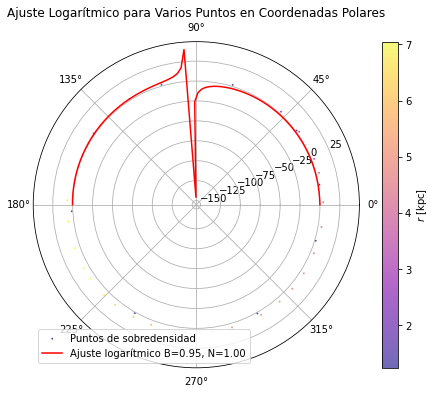

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Definir la función logarítmica para ajustar
def log_spiral(phi, B, N):
    safe_phi = np.clip(phi, 1e-6, None)  # Evitar log(0) o valores negativos
    return 1 / (np.log(B * np.tan(safe_phi / (2 * N)) + 1e-6))

# Función para ajustar el modelo a varios puntos de sobredensidad
def fit_log_spiral_multiple_points_iteratively(r_values, phi_values, initial_guess, max_iters=15000, tol=1e-36):
    B_current, N_current = initial_guess  # Valores iniciales
    for i in range(max_iters):
        try:
            # Ajuste usando curve_fit para múltiples puntos
            params, _ = curve_fit(log_spiral, phi_values, r_values, p0=[B_current, N_current], maxfev=10000)
            B_new, N_new = params
            
            # Mostrar los valores actuales en cada iteración
            print(f"Iteración {i+1}: B = {B_new}, N = {N_new}")
            
            # Verificar si la diferencia es menor que la tolerancia
            if np.abs(B_new - B_current) < tol and np.abs(N_new - N_current) < tol:
                print(f"Convergencia alcanzada en iteración {i+1}.")
                break
            
            # Actualizar los valores actuales
            B_current, N_current = B_new, N_new
            
        except RuntimeError:
            print(f"No se pudo ajustar en la iteración {i+1}, se mantiene el último valor.")
    
    # Devolver los últimos valores ajustados
    return B_current, N_current

# Valores iniciales (r y phi son tus datos convertidos)
r_multiple_points = r_values  # Lista de valores r
phi_multiple_points = phi_values  # Lista de valores phi
initial_guess = [1.0, 1.0]  # Adivinanza inicial de los parámetros B y N

# Ajustar el modelo iterativamente
B_fit, N_fit = fit_log_spiral_multiple_points_iteratively(r_multiple_points, phi_multiple_points, initial_guess)

# Imprimir los parámetros ajustados
print(f"Parámetros ajustados finales: B = {B_fit}, N = {N_fit}")

# Graficar el ajuste
phi_fit = np.linspace(0, np.pi, 100)
r_fit = log_spiral(phi_fit, B_fit, N_fit)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))
sc = ax.scatter(phi_multiple_points, r_multiple_points, c=r_multiple_points, cmap='plasma', s=1, alpha=0.6, label='Puntos de sobredensidad')
ax.plot(phi_fit, r_fit, label=f'Ajuste logarítmico B={B_fit:.2f}, N={N_fit:.2f}', color='r')
ax.set_title('Ajuste Logarítmico para Varios Puntos en Coordenadas Polares')
plt.colorbar(sc, label=r'$r \ [\mathrm{kpc}]$')
plt.legend()
plt.show()


In [10]:
def spiral_structure(phi, A, B, N):
    """
    Calculate r(phi) based on the formula in the article.
    r(φ) = A / log(B * tan(φ / 2N))
    
    Parameters:
    phi : array-like
        Array of angle values in radians.
    A : float
        Scale parameter for the spiral.
    B : float
        Parameter that controls the bulge-to-arm size.
    N : float
        Winding number that controls the spiral's tightness.
    
    Returns:
    r : array-like
        Radial distances corresponding to the angle values.
    """
    r = A / np.log(B * np.tan(phi / (2 * N)))
    return r

# Parameters (adjust as necessary)
A = 10   # Scale factor
B = 1.5  # Bulge-to-arm size parameter
N = 5    # Winding number

# Define phi values ranging from 0 to 2*pi for the spiral
phi = np.linspace(0.1, 2 * np.pi, 1000)

# Calculate the corresponding r values
r_values = spiral_structure(polar_data['theta'][0:1000], A, B, N)

# Convert to Cartesian coordinates for plotting
x_values = r_values * np.cos(polar_data['theta'][0:1000])
y_values = r_values * np.sin(polar_data['theta'][0:1000])

# Plotting the spiral structure
plt.figure(figsize=(8, 8))
plt.scatter(x_values, y_values, label=f'A={A}, B={B}, N={N}')
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.title('Spiral Structure based on Custom Formula')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.legend()
plt.show()


NameError: name 'polar_data' is not defined

In [ ]:
def convert_to_polar(data):
    polar_data = data.copy()
    # El centro de la galaxia está en (0, 0, 0)
    polar_data['r'] = np.sqrt(data['x']**2 + data['y']**2)
    polar_data['theta'] = np.arctan2(data['y'], data['x'])
    return polar_data

polar_data = convert_to_polar(sorted_data)


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# Function to compute the model: r(phi)
def model_r(phi, B, N):
    return 1 / np.log(B * np.tan(phi / (2 * N)))

# Loss function to minimize
def residuals(params, phi_data, r_data):
    B, N = params
    r_model = model_r(phi_data, B, N)
    return r_data - r_model

# Example dataset (r, phi)
phi_data = np.linspace(0.1, 10, 50)  # Replace with actual data
r_data = 1 / np.log(3 * np.tan(phi_data / 4))  # Example data for B=3, N=4

# Initial guess for B and N
initial_guess = [1.0, 1.0]

# Use least squares to find the best-fit B and N
result = least_squares(residuals, initial_guess, args=(phi_data, r_data))

# Extract the estimated B and N
B_est, N_est = result.x
print(f"Estimated B: {B_est}, Estimated N: {N_est}")

# Plot the data and the fitted model
plt.figure(figsize=(8, 6))
plt.scatter(phi_data, r_data, label='Observed Data', color='blue')
plt.plot(phi_data, model_r(phi_data, B_est, N_est), label=f'Fitted Model (B={B_est:.2f}, N={N_est:.2f})', color='red')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$r(\phi)$')
plt.title('Fitting r(phi) using Numerical Optimization')
plt.legend()
plt.grid(True)
plt.show()


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log
/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


ValueError: Residuals are not finite in the initial point.

In [ ]:
r_data = sorted_data['Rs']


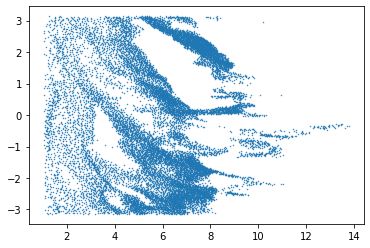

In [80]:
plt.scatter(r_data,polar_data['theta'] , s=0.2) 

In [72]:
def walk_through_particles(data):
    # Aquí irías recorriendo las partículas y haciendo un análisis del gradiente de deltaRho
    
    
    particle_paths = []
    for i, particle in data.iterrows():
        # Puedes añadir condiciones o análisis adicionales de la trayectoria de cada partícula
        
        
        particle_paths.append(particle)
    return particle_paths

# Ejemplo de uso:
particle_paths = walk_through_particles(sorted_data)


In [70]:
import skimage
print(skimage.__version__)


0.14.0


In [71]:


# Crear una malla 2D a partir de los datos
# Supongamos que tienes tus datos de x, y, y deltaRho en sorted_data
x = sorted_data['x']
y = sorted_data['y']
delta_rho = sorted_data['deltaRho']

# Crear una grilla 2D de densidad (usando histograma 2D o interpolación)
grid_size = 100  # Ajustar el tamaño de la malla
H, xedges, yedges = np.histogram2d(x, y, bins=grid_size, weights=delta_rho)

# Suavizar la función de densidad
smoothed_density = ndi.gaussian_filter(H, sigma=1.0)

# Detectar máximos locales
local_maxi = peak_local_max(smoothed_density, indices=False, footprint=np.ones((3, 3)))

# Generar un marcador para el algoritmo de Watershed
markers, _ = ndi.label(local_maxi)

# Aplicar el Watershed transform
labels = watershed(-smoothed_density, markers, mask=smoothed_density)

# Graficar los resultados
plt.figure(figsize=(10, 8))
plt.imshow(smoothed_density, cmap='plasma', origin='lower')
plt.contour(labels, colors='white', linewidths=1)
plt.colorbar(label='Densidad $\Delta \rho$')
plt.title('Segmentation using Watershed Transform')
plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')
plt.show()


NameError: name 'peak_local_max' is not defined